During training of neural networks we traditionally choose the batches to perform updates with uniformly at random without replacement. That is, at the start of each epoch we shuffle the data, chunk them into batches and feed them into the model. In contrast, data (or batch) selection methods aim to cleverly select on what batches to train to reduce training time and improve performance. While previous methods prioritize "hard" data points (with big gradientes or high loss), this paper attempts to select points that most reduce the model's generalization loss.

Remember that the generalization loss essentially refers to the model's performance in previously unseen data, i.e. its test performance. And that if we assume the training and test data are iid, we can estimate it by evaluating the model on a held-out validation set. Thus it seems reasonable to select points that minimize the loss on the validation set. However, note that if we were to do so naively by

- training on a candidate $(x_i, y_i)$ point (forward and backward passes on a single point),
- evaluating the validation loss (computed on the whole validation set),
- repeating for every point and selecting those with lower validation loss

is extremely expensive. This paper proposes a way to

>"(approximately) find the points that would
most reduce the holdout loss if we were to train the current
model on them, without actually training on them".

We won't go into the details of the derivation and approximations performed by the method (see Section 3 of the paper which does a great job), but it boils down to selecting points with

$$
\underset{(x, y) \in B_t}{\text{arg max}} \:\:\: \text{Loss}_M(x, y) - \text{Loss}_{M^*}(x,y)
$$

Where $\text{Loss}_M(x, y)$ refers to the training loss our model $M$ obtains with point $(x, y)$ and $M^*$ is a frozen model trained beforehand on the validation set. The authors refer to $\text{Loss}_{M^*}(x,y)$ as $(x,y)$'s *irreducible holdout loss* (IL) since it represents the lowest (test) loss the model $M$ could achieve without training on it. The difference between the training loss and irreducible holdout loss is then the *reducible holdout loss* (RHO-LOSS). RHO-LOSS *Selection* then proceeds as follows.

Given a pretrained model $M^*$ on a validation set, a batch size $n_b$ and large batch size $n_B > n_b$:

1. Calculate the irreducible holdout loss $\text{Loss}_{M^*}(x_i,y_i)$ for every point in the training set
2. Sample a *super batch* $B$ of size $n_B$ uniformly from the training set
3. Let the batch $b$ be the top $n_b$ points from $B$ in terms of RHO-LOSS
4. Perform a SGD step on $M$ with $b$
5. Go to step 2 if stopping criteria is not met

The authors show that this approach drastically speeds up training when measured in *steps* (see the paper for the parallelization required to achieve faster wall clock times).

## Minimum viable reproduction
We'll first try to see if we can implement the method and apply it to a smaller dataset presented in the paper -- CIFAR-10. Let's get our imports and data.

In [8]:
#| code-summary: Imports and model evaluation function
#| output: false
#| echo: false

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, functools, itertools
import resnet

os.makedirs('logs_tmp', exist_ok = True)
os.makedirs('models_tmp', exist_ok = True)


device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)

def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == 'cuda':
        print('Setting seed for CUDA')
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed()

def eval_model(model, test, criterion = nn.CrossEntropyLoss()):
    model.to(device); model.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
            loss += criterion(model(images), labels).item()
    return loss / len(test.dataset), correct / len(test.dataset)

device

device(type='mps')

In [9]:
#| code-summary: CIFAR-10 dataset and data augmentation
#| output: false
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

data_augmented_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_set = datasets.CIFAR10('../data', download = True, train = True, transform = transform)
test_set = datasets.CIFAR10('../data', download = True, train = False, transform = transform)
train_set_half, val_set = torch.utils.data.random_split(train_set, [len(train_set) // 2, len(train_set) // 2])
n_classes = len(train_set.classes)

Files already downloaded and verified
Files already downloaded and verified


And as in the paper, we split the training data into a `val_set` to train the IL model and a `train_set_half` to train the target (final) model. Baseline approaches such as uniform selection are trained on the whole `train_set`. Finally, all methods are evaluated on a `test_set`.

In [10]:
#| code-fold: false
len(train_set), len(train_set_half), len(val_set), len(test_set)

(50000, 25000, 25000, 10000)

We first train the IL model on the validation set with a standard training loop and the details given in Appendix B.

In [16]:
#| code-summary: Train IL model
#| output: false

# As per Appendix B (and code) of the paper, we train with
# - AdamW optimizer with default parameters
# - CrossEntropyLoss criterion
# - Batch size of 320
# - 100 epochs
# and save the model with the best validation *loss* (not accuracy).
def train_il(model, train, val, epochs = 100, batch_size = 320, save_path = 'models/tmp'):
    model.to(device)
    train.dataset.transform = data_augmented_transform
    train = DataLoader(train, batch_size = batch_size, shuffle = True)
    val = DataLoader(val, batch_size = batch_size, shuffle = False)
    optimizer = optim.AdamW(model.parameters())  # Default params
    criterion = nn.CrossEntropyLoss()
    best_loss = np.inf
    for epoch in range(epochs):
        model.train()
        for images, labels in train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
        val_loss, val_acc = eval_model(model, val)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    
    train.dataset.transform = transform
    return model

il_model = resnet.ResNet18() #models.resnet18(num_classes = n_classes)

# Note we train the IL model on the validation set and validate on the training set.
# Thus, we augment the validation set and not the training set.
il_model = train_il(il_model, train = val_set, val = train_set_half, save_path = 'models_tmp/il_cifar10')

Epoch 1/100, Loss: 0.0052, Accuracy: 0.4291
Epoch 2/100, Loss: 0.0040, Accuracy: 0.5636
Epoch 3/100, Loss: 0.0047, Accuracy: 0.5510
Epoch 4/100, Loss: 0.0029, Accuracy: 0.6794
Epoch 5/100, Loss: 0.0030, Accuracy: 0.6730
Epoch 6/100, Loss: 0.0026, Accuracy: 0.7195
Epoch 7/100, Loss: 0.0029, Accuracy: 0.7012
Epoch 8/100, Loss: 0.0022, Accuracy: 0.7639
Epoch 9/100, Loss: 0.0024, Accuracy: 0.7521
Epoch 10/100, Loss: 0.0021, Accuracy: 0.7801
Epoch 11/100, Loss: 0.0025, Accuracy: 0.7482
Epoch 12/100, Loss: 0.0018, Accuracy: 0.8083
Epoch 13/100, Loss: 0.0018, Accuracy: 0.8116
Epoch 14/100, Loss: 0.0027, Accuracy: 0.7488
Epoch 15/100, Loss: 0.0019, Accuracy: 0.8041
Epoch 16/100, Loss: 0.0021, Accuracy: 0.7910
Epoch 17/100, Loss: 0.0019, Accuracy: 0.8045
Epoch 18/100, Loss: 0.0017, Accuracy: 0.8286
Epoch 19/100, Loss: 0.0020, Accuracy: 0.8064
Epoch 20/100, Loss: 0.0017, Accuracy: 0.8269
Epoch 21/100, Loss: 0.0022, Accuracy: 0.8042
Epoch 22/100, Loss: 0.0022, Accuracy: 0.8033
Epoch 23/100, Loss:

KeyboardInterrupt: 

In [18]:
#| code-fold: false
il_model = resnet.ResNet18() #models.resnet18(num_classes = n_classes)
il_model.load_state_dict(torch.load('models_tmp/il_cifar10'))
loss, acc = eval_model(il_model, DataLoader(test_set, batch_size = 320))
loss, acc

(0.001616067612171173, 0.8688)

And we evaluate the loss of points in `train_set_half` with the IL model as we will need them to compute the reducible losses.

In [33]:
def get_il_losses(model, data_loader):
    """Return the loss for each example."""
    model.to(device); model.eval()
    n, batch_size = len(data_loader.dataset), data_loader.batch_size
    losses = torch.zeros(n); i = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            losses[i : min(i + batch_size, n)] = nn.CrossEntropyLoss(reduction = 'none')(model(images), labels)
            i += batch_size
    return losses

precomputed = True
if not precomputed:
    il_losses = get_il_losses(il_model, DataLoader(train_set_half, batch_size = 320))
    torch.save(il_losses, 'logs_tmp/il_losses_cifar10')
    il_losses = il_losses.to(device)
else:
    il_losses = torch.load('logs_tmp/il_losses_cifar10')
    il_losses = il_losses.to(device)

il_losses

tensor([2.1935e-02, 1.5020e-05, 5.6980e-05,  ..., 4.2016e-03, 1.1921e-07,
        3.0477e-04], device='mps:0')

Next, we define different selection functions which will take the indices, images and labels of a superbatch $B$ of size $n_B$ and return (the indices) of batch $b$ of size $n_b$ we train on. We define the baseline uniform selection, the paper's RHO-LOSS selection and a probabalistic version of it which samples points according to their reducible loss (instead of always picking the highest ones).

In [34]:
def get_reducible_loss(model, cand_ixs, cand_images, cand_labels):
    irreducible_loss = il_losses[cand_ixs]
    train_loss = nn.CrossEntropyLoss(reduction = 'none')(model(cand_images), cand_labels)
    return train_loss - irreducible_loss

def rho_selection(model, cand_ixs, cand_images, cand_labels, n_b, eval_mode = False):
    # Returns of the top b examples with the highest reducible loss
    if eval_mode: model.eval()
    reducible_loss = get_reducible_loss(model, cand_ixs, cand_images, cand_labels)
    if eval_mode: model.train()
    return torch.topk(reducible_loss, n_b, largest = True).indices

def rho_prob_selection(model, cand_ixs, cand_images, cand_labels, n_b, eval_mode = False):
    # Samples b examples without replament withted by reducible loss
    if eval_mode: model.eval()
    reducible_loss = get_reducible_loss(model, cand_ixs, cand_images, cand_labels)
    if eval_mode: model.train()
    return torch.multinomial(torch.relu(reducible_loss), n_b, replacement = False)

def uniform_selection(model, cand_ixs, cand_images, cand_labels, n_b):
    # Returns b examples sampled uniformly at random
    return torch.randperm(len(cand_ixs))[:n_b]

In [35]:
#| code-summary: Target model training loop
#| output: false

# Dataset wrapper so dataloader returns indices as well
class IndexedDataset(Dataset):
    def __init__(self, dataset): self.dataset = dataset
    def __getitem__(self, i): return i, self.dataset[i]
    def __len__(self): return len(self.dataset)


def train_target_model(model, train, val, test, epochs, n_B, n_b, selection_fn, model_path = 'models/tmp', log_path = 'logs/tmp'):

    dataset = train.dataset if isinstance(train, torch.utils.data.Subset) else train
    dataset.transform = data_augmented_transform

    model.to(device)
    train = DataLoader(IndexedDataset(train), batch_size = n_B, shuffle = True)
    val = DataLoader(val, batch_size = n_b, shuffle = False)
    test = DataLoader(test, batch_size = n_b, shuffle = False)
    optimizer = optim.AdamW(model.parameters())  # Default params
    criterion = nn.CrossEntropyLoss()

    val_accs, test_accs = [], []
    for epoch in range(epochs):
        model.train()
        for indices, (cand_images, cand_labels) in train:
            cand_images, cand_labels = cand_images.to(device), cand_labels.to(device)

            with torch.no_grad():
                b_indices = selection_fn(model, indices, cand_images, cand_labels, n_b)
            images, labels = cand_images[b_indices], cand_labels[b_indices]

            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()

        _, val_acc = eval_model(model, val)
        _, test_acc = eval_model(model, test)
        val_accs.append(val_acc); test_accs.append(test_acc)
        print(f'Epoch {epoch + 1}/{epochs}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}, ')
    
    dataset.transform = transform
    torch.save({'val_accs': val_accs, 'test_accs': test_accs}, log_path)
    torch.save(model.state_dict(), model_path)

In [36]:
#| code-summary: Train grid of target models
#| output: false
prod = itertools.product(
    [rho_selection, rho_prob_selection, uniform_selection],
    [320], # [512, 256],
    [1/10], # [1/16, 1/8, 1/4],
    range(3)
)
for selection_fn, n_B, n_b_frac, seed in prod:
    fname = f'target_{n_B}_{n_b_frac}_{seed}_{selection_fn.__name__.replace("_selection", "")}'
    n_b = int(n_B * n_b_frac)
    print(fname, n_b)

    # Baselines train on whole training set
    train = train_set_half if selection_fn != uniform_selection else train_set
    
    set_seed(seed)
    target_model = resnet.ResNet18()
    train_target_model(target_model, train = train, val = val_set, test = test_set,
                       epochs = 100, n_B = n_B, n_b = n_b, selection_fn = selection_fn,
                       model_path = f'models_tmp/{fname}', log_path = f'logs_tmp/{fname}')

target_320_0.1_0_rho 32
Epoch 1/100, Val Acc: 0.2008, Test Acc: 0.2280, 
Epoch 2/100, Val Acc: 0.3127, Test Acc: 0.3128, 
Epoch 3/100, Val Acc: 0.3250, Test Acc: 0.3121, 
Epoch 4/100, Val Acc: 0.3514, Test Acc: 0.3739, 
Epoch 5/100, Val Acc: 0.4551, Test Acc: 0.4400, 
Epoch 6/100, Val Acc: 0.3996, Test Acc: 0.4195, 
Epoch 7/100, Val Acc: 0.4105, Test Acc: 0.4231, 
Epoch 8/100, Val Acc: 0.4442, Test Acc: 0.4539, 
Epoch 9/100, Val Acc: 0.4839, Test Acc: 0.5025, 
Epoch 10/100, Val Acc: 0.5548, Test Acc: 0.5634, 
Epoch 11/100, Val Acc: 0.5572, Test Acc: 0.5682, 
Epoch 12/100, Val Acc: 0.5752, Test Acc: 0.5925, 
Epoch 13/100, Val Acc: 0.5968, Test Acc: 0.5988, 
Epoch 14/100, Val Acc: 0.6460, Test Acc: 0.6434, 
Epoch 15/100, Val Acc: 0.6158, Test Acc: 0.6217, 
Epoch 16/100, Val Acc: 0.6831, Test Acc: 0.6744, 
Epoch 17/100, Val Acc: 0.7047, Test Acc: 0.7003, 
Epoch 18/100, Val Acc: 0.6586, Test Acc: 0.6609, 
Epoch 19/100, Val Acc: 0.7298, Test Acc: 0.7286, 
Epoch 20/100, Val Acc: 0.7271, Test

KeyboardInterrupt: 

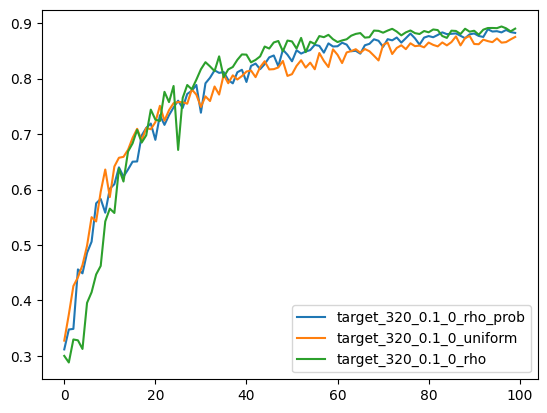

In [27]:
for fname in os.listdir('logs_tmp'):
    if 'target' not in fname: continue
    path = f'logs_tmp/{fname}'
    test_accs = torch.load(path)['test_accs']
    plt.plot(test_accs, label = fname)
    # print(f'{fname} {torch.load(path)["test_accs"][-1]:.4f}')

plt.legend()

Error: target_256_0.125_2_uniform


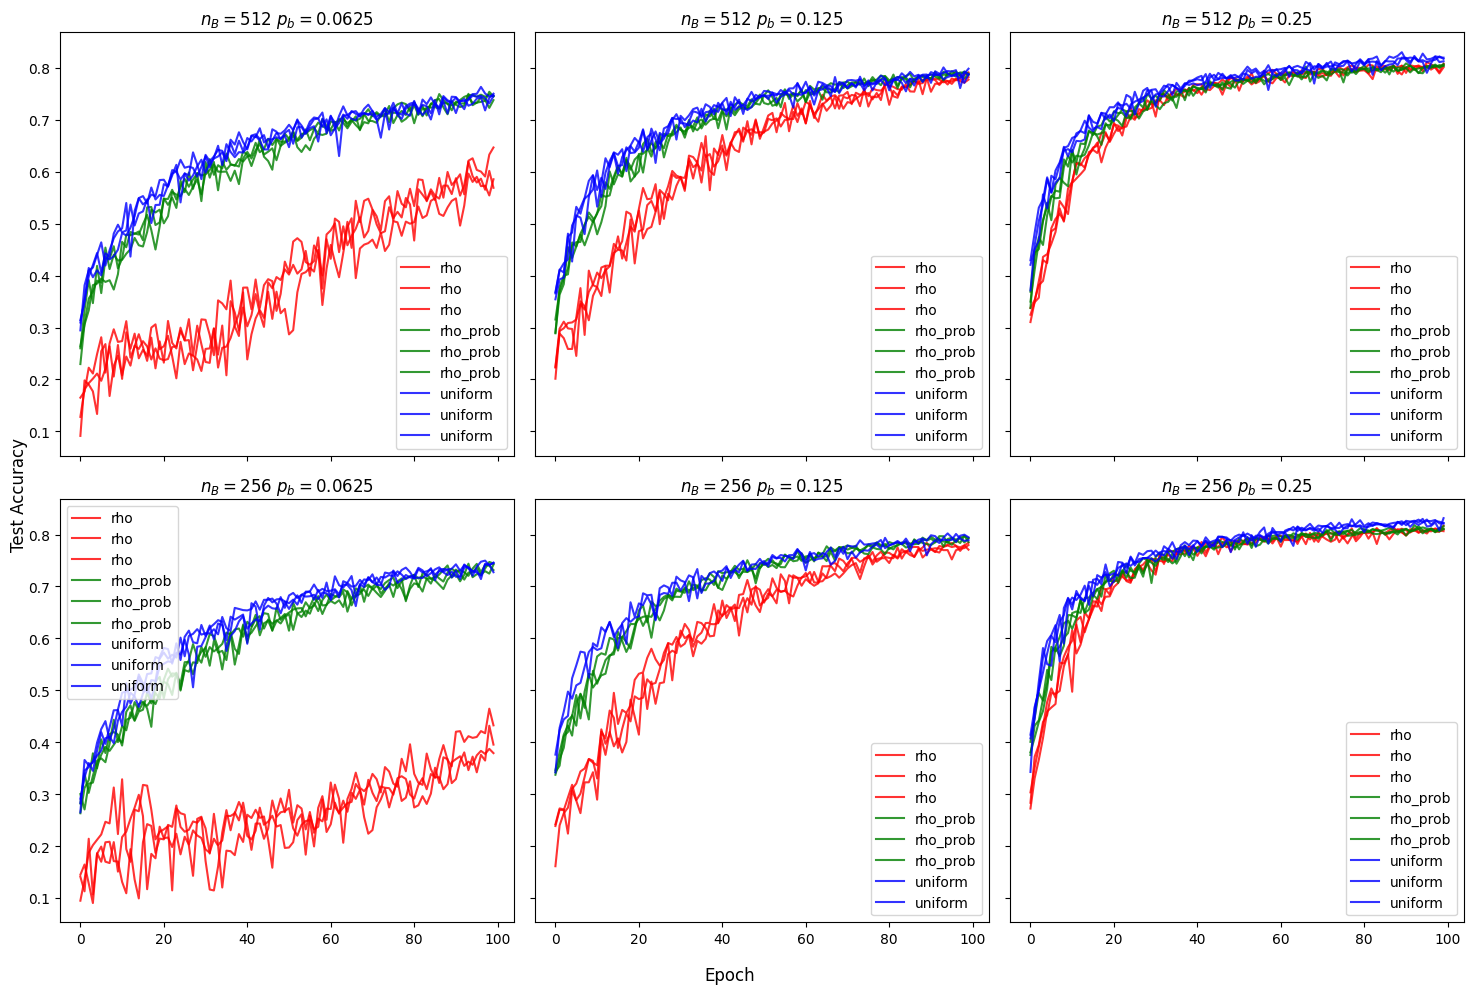

In [243]:
f, axs = plt.subplots(2, 3, figsize = (15, 10), sharex = True, sharey = True)
colors = ['r', 'g', 'b']

for row, n_B in enumerate([512, 256]):
    for col, n_b_frac in enumerate([1/16, 1/8, 1/4]):
        for j, selection_fn in enumerate([rho_selection, rho_prob_selection, uniform_selection]):
            ax = axs[row][col]
            for seed in range(3):
                n_b = int(n_B * n_b_frac)
                sel_name = selection_fn.__name__.replace("_selection", "")
                fname = f'target_{n_B}_{n_b_frac}_{seed}_{sel_name}'
                try:
                    log = torch.load(f'logs/{fname}')
                    ax.plot(log['test_accs'], label = sel_name, color = colors[j], alpha = 0.8)
                except: print(f'Error: {fname}')
            ax.set_title(r'$n_B = $' + f'{n_B}' + ' $p_b = $' + f'{n_b_frac}')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.legend()

f.supxlabel('Epoch')
f.supylabel('Test Accuracy')
f.tight_layout()

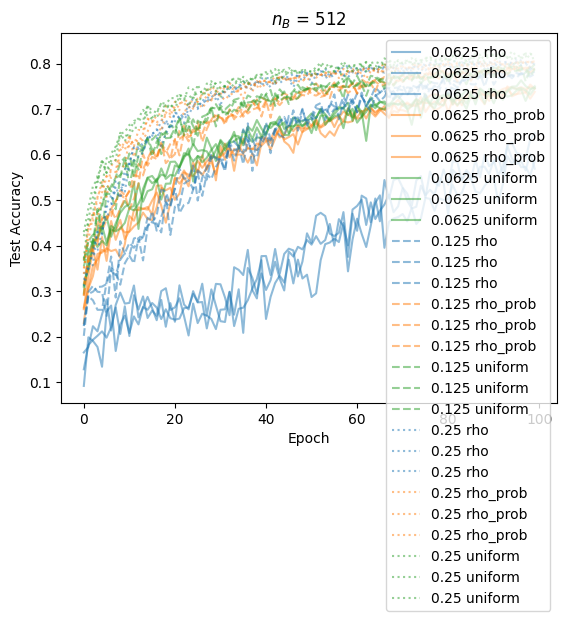

In [224]:
# 512 vs 256 on diff plots
# colors map to n_b_frac
# line styles map to selection_fn
colors = sns.color_palette('tab10')
linestyles = ['-', '--', ':']

for n_B in [512, 256]:
    fig, ax = plt.subplots()
    for i, n_b_frac in enumerate([1/16, 1/8, 1/4]):
        for j, selection_fn in enumerate([rho_selection, rho_prob_selection, uniform_selection]):
            for seed in range(3):
                n_b = int(n_B * n_b_frac)
                sel_name = selection_fn.__name__.replace("_selection", "")
                fname = f'target_{n_B}_{n_b_frac}_{seed}_{sel_name}'
                log = torch.load(f'logs/{fname}')
                ax.plot(log['test_accs'], label = f'{n_b_frac} {sel_name}', color = colors[j], linestyle = linestyles[i], alpha = 0.5)

    ax.set_title(r'$n_B$ = '+ f'{n_B}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.legend()

    # handles, labels = ax.get_gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys())

    plt.show()
    break

In [201]:
sns.color_palette('tab10')[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [203]:
colors = sns.color_palette('tab10')
colors_ = set([])

for fname in os.listdir('logs'):
    if 'target' not in fname: continue
    n_B, n_b_frac, seed, selection_fn = fname.split('_')[1:]
    colors_.add((n_b_frac, selection_fn))
    
#     d[(n_B, n_b_frac, selection_fn)] = torch.load(f'logs/{fname}')
#     # if '512' not in n_B or '0' not in n_b_frac: continue
#     data = torch.load(f'logs/{fname}')
#     plt.plot(data['test_accs'], label = fname, color = colors[0])

# plt.legend()
colors_

{('0.0625', 'rho'),
 ('0.0625', 'uniform'),
 ('0.125', 'rho'),
 ('0.125', 'uniform'),
 ('0.25', 'rho'),
 ('0.25', 'uniform')}

In [ ]:
for fname, name in zip(['target_cifar10_uniform', 'target_cifar10', 'target_cifar10_eval'], ['Uniform', 'Rho', 'Rho Eval']):
    d = torch.load(f'logs/{fname}.log')
    plt.plot(d['test_accs'], label = name)

plt.legend()

# What I learned about
- checkpointing